In [1]:
import numpy as np
import pandas as pd
import xarray as xr
import xagg as xa
import geopandas as gp
import rioxarray as rio
from shapely.geometry import mapping
import dask

import matplotlib.pyplot as plt
import matplotlib
from matplotlib.lines import Line2D

import pyproj
pyproj.datadir.set_data_dir('/storage/home/d/dcl5300/work/ENVS/cropswitching/share/proj')

import warnings
warnings.simplefilter("ignore", RuntimeWarning) # Ignore invalid arcsin() in EDD calculation
pd.set_option('mode.chained_assignment', None) # Ignore copy assignment warning

dask.config.set({'array.slicing.split_large_chunks': False})

font = {'size'   : 18}
matplotlib.rc('font', **font)

/storage/home/dcl5300/work/ENVS/yield_hindcast_uq/lib/python3.9/site-packages/pyproj/datadir.py:38: UserWarning: pyproj unable to set database path.
  _global_context_set_data_dir()


## Dask (cluster)

In [28]:
from dask_jobqueue import PBSCluster
cluster = PBSCluster(cores=1, resource_spec='pmem=20GB', memory='20GB', walltime='00:40:00')

In [29]:
print(cluster.job_script())

#!/usr/bin/env bash

#PBS -N dask-worker
#PBS -A kaf26_c_g_sc_default
#PBS -l pmem=20GB
#PBS -l walltime=00:40:00
#PBS -e /gpfs/scratch/dcl5300/
#PBS -o /gpfs/scratch/dcl5300/

/storage/work/dcl5300/ENVS/cropswitching/bin/python -m distributed.cli.dask_worker tcp://10.102.201.186:38802 --nthreads 1 --memory-limit 18.63GiB --name dummy-name --nanny --death-timeout 60 --local-directory /gpfs/scratch/dcl5300 --protocol tcp://



In [30]:
cluster.scale(jobs=20)  # ask for jobs

In [31]:
from dask.distributed import Client
client = Client(cluster)

In [32]:
client

Connection method: Cluster object,Cluster type: PBSCluster
Dashboard: /proxy/8787/status,
Dashboard: /proxy/8787/status,Workers: 0
Total threads: 0,Total memory: 0 B
Comm: tcp://10.102.201.186:38802,Workers: 0
Dashboard: /proxy/8787/status,Total threads: 0
Started: Just now,Total memory: 0 B


## 35C days

In [183]:
####################################################################################
##################### NEX-GDDP (CMIP5) #############################################
# https://www.nccs.nasa.gov/services/data-collections/land-based-products/nex-gddp
####################################################################################

In [33]:
# Get list of models
models = !ls /gpfs/group/kaf26/default/public/NEX-GDDP/raw/tasmax_day_BCSD_rcp45_r1i1p1_*
models = [model.replace('/gpfs/group/kaf26/default/public/NEX-GDDP/raw/tasmax_day_BCSD_rcp45_r1i1p1_','') for model in models]
models = [model[:-8] for model in models]
models = [model.replace('.nc','') for model in models]
models = np.unique(models)

nex_path = '/gpfs/group/kaf26/default/public/NEX-GDDP/raw/tasmax_day_BCSD_rcp45_r1i1p1_'

In [34]:
len(models)

21

In [36]:
# Gridcell-days
ds_out = []

for model in models:
    # Read data
    ds = xr.open_mfdataset(nex_path + model + '*', chunks='auto')
    ds = ds.sel(time=ds.time.dt.year.isin(np.arange(2040, 2061)))
    ds = ds.rio.write_crs(us_gdf.crs.to_string())
    
    # Calculate no. of grid-cell days > 30C, summed over year, averaged over 2040-2060
    ds = xr.where(ds['tasmax'] > (35 + 273.15), 1, 0).resample(time='Y').sum().mean(dim='time').compute()
    
    # Global
    gridcell_global.append(ds.sum())
    
    # Some adjustments for subsetting via shapefiles
    ds['lon'] = [lon if (lon < 180.) else (lon - 360.) for lon in ds['lon']]
    ds = ds.sortby(ds['lon'])
    
    ds_out.append(ds) # Save for people days

In [ ]:
# Store
ds_out_named = []
for i in range(len(models)):
    ds = ds_out[i]
    ds = ds.rename(models[i])
    ds_out_named.append(ds)
    
ds_final = xr.merge(ds_out_named)
ds_final.attrs['NOTE'] = 'Days with tasmax > 35C, 2050-2070 mean under RCP4.5'

ds_final.to_netcdf('../data/nex_gddp_35c_days/nex_gddp_all_2050-2060_mean_35c_days.nc')

## Population & People days

In [2]:
##########################################################################
##################### Jones & O'Neill (2016) #############################
# Ref: https://iopscience.iop.org/article/10.1088/1748-9326/11/8/084003
# Data: https://sedac.ciesin.columbia.edu/data/set/popdynamics-1-8th-pop-base-year-projection-ssp-2000-2100-rev01
##########################################################################

jo16_ssp1_2050 = xr.open_dataset('../data/pop_eighth_degree_SSP/SSP1/Total/NetCDF/ssp1_2050.nc')['ssp1_2050']
jo16_ssp1_2050 = jo16_ssp1_2050.rio.write_crs('WGS 84')
jo16_ssp1_2050.attrs['method'] = 'jo16'

jo16_ssp2_2050 = xr.open_dataset('../data/pop_eighth_degree_SSP/SSP2/Total/NetCDF/ssp2_2050.nc')['ssp2_2050']
jo16_ssp2_2050 = jo16_ssp2_2050.rio.write_crs('WGS 84')
jo16_ssp2_2050.attrs['method'] = 'jo16'

jo16_ssp3_2050 = xr.open_dataset('../data/pop_eighth_degree_SSP/SSP3/Total/NetCDF/ssp3_2050.nc')['ssp3_2050']
jo16_ssp3_2050 = jo16_ssp3_2050.rio.write_crs('WGS 84')
jo16_ssp3_2050.attrs['method'] = 'jo16'

jo16_ssp4_2050 = xr.open_dataset('../data/pop_eighth_degree_SSP/SSP4/Total/NetCDF/ssp4_2050.nc')['ssp4_2050']
jo16_ssp4_2050 = jo16_ssp4_2050.rio.write_crs('WGS 84')
jo16_ssp4_2050.attrs['method'] = 'jo16'

jo16_ssp5_2050 = xr.open_dataset('../data/pop_eighth_degree_SSP/SSP5/Total/NetCDF/ssp5_2050.nc')['ssp5_2050']
jo16_ssp5_2050 = jo16_ssp5_2050.rio.write_crs('WGS 84')
jo16_ssp5_2050.attrs['method'] = 'jo16'

jo16_all_2050 = [jo16_ssp1_2050, jo16_ssp2_2050, jo16_ssp3_2050, jo16_ssp4_2050, jo16_ssp5_2050]

# base = rio.open_rasterio('../data/pop_eighth_degree_SSP/popdynamics-1-8th-pop-base-year-projection-ssp-2000-2100-rev01-byr-netcdf/Base_year_data_2000_NetCDF/2000total.nc')
# base = base.rio.write_crs(il_gdf.crs.to_string())

In [3]:
##############################################################################
##################### Zoraghein & O'Neill (2020) #############################
# Ref: https://www.mdpi.com/2071-1050/12/8/3374
# Data: https://zenodo.org/record/3756179#.YZLAoFNMH0o
# Github: https://github.com/IMMM-SFA/population_gravity
# NOTE: US only, SSPs 3,4,5 only
#############################################################################

zo20_ssp2_2050 = xr.open_dataset('../data/zoraghein-oneill_population_gravity_national-ssp-maps/zoraghein-oneill_population_gravity_national-ssp-maps/National_1km_SSP2_Total_2050.tif')['band_data']
zo20_ssp2_2050 = zo20_ssp2_2050.rio.reproject(jo16_ssp1_2050.spatial_ref.crs_wkt)
zo20_ssp2_2050 = zo20_ssp2_2050.rio.write_crs(jo16_ssp1_2050.spatial_ref.crs_wkt)
zo20_ssp2_2050.attrs['method'] = 'zo20'
zo20_ssp2_2050 = zo20_ssp2_2050.rename('ssp2_2050')

zo20_ssp3_2050 = xr.open_dataset('../data/zoraghein-oneill_population_gravity_national-ssp-maps/zoraghein-oneill_population_gravity_national-ssp-maps/National_1km_SSP3_Total_2050.tif')['band_data']
zo20_ssp3_2050 = zo20_ssp3_2050.rio.reproject(jo16_ssp1_2050.spatial_ref.crs_wkt)
zo20_ssp3_2050 = zo20_ssp3_2050.rio.write_crs(jo16_ssp1_2050.spatial_ref.crs_wkt)
zo20_ssp3_2050.attrs['method'] = 'zo20'
zo20_ssp3_2050 = zo20_ssp3_2050.rename('ssp3_2050')

zo20_ssp5_2050 = xr.open_dataset('../data/zoraghein-oneill_population_gravity_national-ssp-maps/zoraghein-oneill_population_gravity_national-ssp-maps/National_1km_SSP5_Total_2050.tif')['band_data']
zo20_ssp5_2050 = zo20_ssp5_2050.rio.reproject(jo16_ssp1_2050.spatial_ref.crs_wkt)
zo20_ssp5_2050 = zo20_ssp5_2050.rio.write_crs(jo16_ssp1_2050.spatial_ref.crs_wkt)
zo20_ssp5_2050.attrs['method'] = 'zo20'
zo20_ssp5_2050 = zo20_ssp5_2050.rename('ssp5_2050')

zo20_all_2050 = [zo20_ssp2_2050, zo20_ssp3_2050, zo20_ssp5_2050]

In [4]:
##############################################################################
##################### Murakami & Yamagata (2019) #############################
# Ref: https://www.mdpi.com/2071-1050/11/7/2106
# Data (original): https://www.cger.nies.go.jp/gcp/population-and-gdp.html
# Data (cleaned): https://github.com/Nowosad/global_population_and_gdp
# NOTE original data was not on standard grid, instead was a shapefile with e.g.
# country boundaries and zeros removed
#############################################################################

my19_ssp1_2050 = xr.open_dataset('../data/murakami_yamagata_2019/data/p1_2050.tif')['band_data'] * 1e6 # convert from millions
my19_ssp1_2050 = my19_ssp1_2050.rename('ssp1_2050')
my19_ssp1_2050 = my19_ssp1_2050.rename({'x' : 'lon', 'y' : 'lat'})
my19_ssp1_2050 = my19_ssp1_2050.rio.write_crs('epsg:4326')
my19_ssp1_2050.attrs['method'] = 'my19'

my19_ssp2_2050 = xr.open_dataset('../data/murakami_yamagata_2019/data/p2_2050.tif')['band_data'] * 1e6
my19_ssp2_2050 = my19_ssp2_2050.rename('ssp2_2050')
my19_ssp2_2050 = my19_ssp2_2050.rename({'x' : 'lon', 'y' : 'lat'})
my19_ssp2_2050 = my19_ssp2_2050.rio.write_crs('epsg:4326')
my19_ssp2_2050.attrs['method'] = 'my19'

my19_ssp3_2050 = xr.open_dataset('../data/murakami_yamagata_2019/data/p3_2050.tif')['band_data'] * 1e6
my19_ssp3_2050 = my19_ssp3_2050.rename('ssp3_2050')
my19_ssp3_2050 = my19_ssp3_2050.rename({'x' : 'lon', 'y' : 'lat'})
my19_ssp3_2050 = my19_ssp3_2050.rio.write_crs('epsg:4326')
my19_ssp3_2050.attrs['method'] = 'my19'

my19_all_2050 = [my19_ssp1_2050, my19_ssp2_2050, my19_ssp3_2050]

In [5]:
# Climate data
nex_35c_days = xr.open_dataset('../data/nex_gddp_35c_days/nex_gddp_all_2050-2060_mean_35c_days.nc')

In [6]:
%%time
# Global
global_out = []

for pop_set in [jo16_all_2050, my19_all_2050]:
    for pop in pop_set:
        # Record info
        ssp = pop.name[:4]
        method = pop.attrs['method']
        
        ## Population
        pop_only = float(pop.where(pop > 0.).sum().values)
        
        for model in nex_35c_days.data_vars:
            ## Gridcell days
            gridcell_days = float(nex_35c_days[model].sum().values)
            
            ## People days
            # Interpolate climate data from 1/4 to 1/8 degree grid
            ds = nex_35c_days[model].interp_like(pop, method='nearest') 

            # Calculate people days
            people_days = float((ds * pop.where(pop > 0.)).sum().values)
            
            ## Append all
            out = pd.DataFrame({'ssp':ssp, 'method':method, 'model':model, 
                   'pop':pop_only, 'gridcell_days':gridcell_days, 'people_days':people_days}, index=[0])
            
            global_out.append(out)
            
# Normalize
global_out = pd.concat(global_out, ignore_index=True)
global_out['pop_med'] = global_out['pop'] / global_out['pop'].median()
global_out['gridcell_days_med'] = global_out['gridcell_days'] / global_out['gridcell_days'].median()
global_out['people_days_med'] = global_out['people_days'] / global_out['people_days'].median()

CPU times: user 6.74 s, sys: 1.21 s, total: 7.95 s
Wall time: 10.8 s


In [7]:
# Read US shapefile
us_gdf = gp.read_file('../data/us_county_shapefile/counties_contig_plot.shp')
us_gdf['state'] = us_gdf['fips'].astype(str).str[:2]
us_gdf = us_gdf.to_crs('WGS 84') # lat/lon

il_gdf = us_gdf.query('state == "17"')
county_gdf = us_gdf.query('fips == "17019"')

In [8]:
%%time
# US
us_out = []

for pop_set in [zo20_all_2050, jo16_all_2050, my19_all_2050]:
    for pop in pop_set:
        # Record info
        ssp = pop.name[:4]
        method = pop.attrs['method']
        
        # Clip
        if 'lat' in pop.coords:
            pop = pop.rename({'lat' : 'y', 'lon' : 'x'})
            
        pop = pop.rio.clip(us_gdf.geometry.apply(mapping), us_gdf.crs)
            
        # Population
        pop_only = float(pop.where(pop > 0.).sum().values)

        for model in nex_35c_days.data_vars:
            # Clip
            ds_clip = nex_35c_days[model]
            
            if 'lat' in ds_clip.coords:
                ds_clip = ds_clip.rename({'lat' : 'y', 'lon' : 'x'})

            ds_clip = ds_clip.rio.clip(us_gdf.geometry.apply(mapping), us_gdf.crs)
            
            # Gridcell days
            gridcell_days = float(ds_clip.sum().values)

            # People days
            ds_clip = ds_clip.interp_like(pop, method='nearest') # Interpolate climate data from 1/4 degree
            people_days = float((ds_clip * pop.where(pop > 0.)).sum().values)

            # Append all
            out = pd.DataFrame({'ssp':ssp, 'method':method, 'model':model, 
                   'pop':pop_only, 'gridcell_days':gridcell_days, 'people_days':people_days}, index=[0])
            
            us_out.append(out)
            
# Normalize
us_out = pd.concat(us_out, ignore_index=True)
us_out['pop_med'] = us_out['pop'] / us_out['pop'].median()
us_out['gridcell_days_med'] = us_out['gridcell_days'] / us_out['gridcell_days'].median()
us_out['people_days_med'] = us_out['people_days'] / us_out['people_days'].median()

CPU times: user 3min 8s, sys: 6.78 s, total: 3min 15s
Wall time: 3min 17s


In [28]:
%%time
# IL
il_out = []

for pop_set in [zo20_all_2050, jo16_all_2050, my19_all_2050]:
    for pop in pop_set:
        # Record info
        ssp = pop.name[:4]
        method = pop.attrs['method']
        
        # Clip
        if 'lat' in pop.coords:
            pop = pop.rename({'lat' : 'y', 'lon' : 'x'})
            
        pop = pop.rio.clip(il_gdf.geometry.apply(mapping), il_gdf.crs)
            
        # Population
        pop_only = float(pop.where(pop > 0.).sum().values)

        for model in nex_35c_days.data_vars:
            # Clip
            ds_clip = nex_35c_days[model]
            
            if 'lat' in ds_clip.coords:
                ds_clip = ds_clip.rename({'lat' : 'y', 'lon' : 'x'})

            ds_clip = ds_clip.rio.clip(il_gdf.geometry.apply(mapping), il_gdf.crs)
            
            # Gridcell days
            gridcell_days = float(ds_clip.sum().values)

            # People days
            ds_clip = ds_clip.interp_like(pop, method='nearest') # Interpolate climate data from 1/4 degree
            people_days = float((ds_clip * pop.where(pop > 0.)).sum().values)

            # Append all
            out = pd.DataFrame({'ssp':ssp, 'method':method, 'model':model, 
                   'pop':pop_only, 'gridcell_days':gridcell_days, 'people_days':people_days}, index=[0])
            
            il_out.append(out)

CPU times: user 12.8 s, sys: 147 ms, total: 12.9 s
Wall time: 13.1 s


In [29]:
# Normalize
il_out = pd.concat(il_out, ignore_index=True)

# There are three massive outlier models: choose to drop or not
outliers = il_out.drop_duplicates(subset=['gridcell_days']).sort_values(by='gridcell_days')['model'][-3:]
il_out_no_outliers = il_out[~il_out.model.isin(outliers)] # Can choose to drop outliers or not 

il_out_plot = il_out_no_outliers.copy()

il_out_plot['pop_med'] = il_out_plot['pop'] / il_out_plot['pop'].median()
il_out_plot['gridcell_days_med'] = il_out_plot['gridcell_days'] / il_out_plot['gridcell_days'].median()
il_out_plot['people_days_med'] = il_out_plot['people_days'] / il_out_plot['people_days'].median()

In [26]:
%%time
# County
county_out = []

for pop_set in [zo20_all_2050, jo16_all_2050, my19_all_2050]:
    for pop in pop_set:
        # Record info
        ssp = pop.name[:4]
        method = pop.attrs['method']
        
        # Clip
        if 'lat' in pop.coords:
            pop = pop.rename({'lat' : 'y', 'lon' : 'x'})
            
        pop = pop.rio.clip(county_gdf.geometry.apply(mapping), county_gdf.crs)
            
        # Population
        pop_only = float(pop.where(pop > 0.).sum().values)

        for model in nex_35c_days.data_vars:
            # Clip
            ds_clip = nex_35c_days[model]
            
            if 'lat' in ds_clip.coords:
                ds_clip = ds_clip.rename({'lat' : 'y', 'lon' : 'x'})

            ds_clip = ds_clip.rio.clip(county_gdf.geometry.apply(mapping), county_gdf.crs)
            
            # Gridcell days
            gridcell_days = float(ds_clip.sum().values)

            # People days
            ds_clip = ds_clip.interp_like(pop, method='nearest') # Interpolate climate data from 1/4 degree
            people_days = float((ds_clip * pop.where(pop > 0.)).sum().values)

            # Append all
            out = pd.DataFrame({'ssp':ssp, 'method':method, 'model':model, 
                   'pop':pop_only, 'gridcell_days':gridcell_days, 'people_days':people_days}, index=[0])
            
            county_out.append(out)

CPU times: user 7.8 s, sys: 210 ms, total: 8.01 s
Wall time: 8.03 s


In [27]:
# Normalize
county_out = pd.concat(county_out, ignore_index=True)

# There are three massive outlier climate models; choose to drop or not
outliers = county_out.drop_duplicates(subset=['gridcell_days']).sort_values(by='gridcell_days')['model'][-3:]
county_out_no_outliers = county_out[~county_out.model.isin(outliers)] # Can choose to drop outliers or not 

county_out_plot = county_out_no_outliers.copy()

county_out_plot['pop_med'] = county_out_plot['pop'] / county_out_plot['pop'].median()
county_out_plot['gridcell_days_med'] = county_out_plot['gridcell_days'] / county_out_plot['gridcell_days'].median()
county_out_plot['people_days_med'] = county_out_plot['people_days'] / county_out_plot['people_days'].median()

# Plot

In [176]:
# For plots
ssp_marker_map = {'ssp1': '^', 'ssp2': '>', 'ssp3' : 'v', 'ssp4' : '<', 'ssp5' : 'o'}
method_color_map = {'jo16' : '#1b9e77', 'my19' : '#d95f02', 'zo20' : '#7570b3'}

In [177]:
# Functions to draw boxplots
def draw_pop_boxplot(data, ax, pos):
    # Boxes
    bp_pop = ax.boxplot(data['pop_med'], positions=[pos],
               medianprops=dict(linewidth=lw, color='white'),
               boxprops=dict(linewidth=lw, color=color),
               whiskerprops=dict(linewidth=lw, color=color),
               capprops=dict(linewidth=lw, color=color),
               showfliers=True, widths=width, whis=(0,100),
               patch_artist=True)

    # Boxplot color
    for patch in bp_pop['boxes']:
        patch.set_facecolor(color)
    
    # Labels
    for ssp in ssp_marker_map.keys():
        for method in method_color_map.keys():
            data_unique_plot = data.query('ssp == "' + ssp + '" and method == "' + method + '"')
            ax.scatter(x=[pos]*len(data_unique_plot), y=data_unique_plot['pop_med'], 
                       marker=ssp_marker_map[ssp], 
                       color=method_color_map[method],
                       zorder=100,
                       s=ms)

def draw_gricell_boxplot(data, ax, pos):
    # Boxes
    bp_gc = ax.boxplot(data['gridcell_days_med'], positions=[pos],
                       medianprops=dict(linewidth=lw, color='white'),
                       boxprops=dict(linewidth=lw, color=color),
                       whiskerprops=dict(linewidth=lw, color=color),
                       capprops=dict(linewidth=lw, color=color),
                       showfliers=True, widths=width,
                       whis=(0,100),
                       patch_artist=True)
    # Boxplot colors
    for patch in bp_gc['boxes']:
        patch.set_facecolor(color)

    # Labels    
    ax.scatter(x = [pos]*len(data), y=data['gridcell_days_med'], marker='_', s=ms, zorder=100, color='black')
    
def draw_ppldays_boxplot(data, ax, pos):
    # Boxes
    bp_ppl = ax.boxplot(data['people_days_med'], positions=[pos],
                medianprops=dict(linewidth=lw, color='white'),
               boxprops=dict(linewidth=lw, color=color),
               whiskerprops=dict(linewidth=lw, color=color),
               capprops=dict(linewidth=lw, color=color),
               showfliers=True, widths=width,
               patch_artist=True, whis=(0,100))

    # Boxplot color
    for patch in bp_ppl['boxes']:
        patch.set_facecolor(color)
    
    # Labels
    data_sample = pd.concat([data.sort_values(by='people_days_med')[::8], pd.DataFrame(data.sort_values(by='people_days_med').iloc[-1]).T]) # sample only every 8th marker otherwise becomes too cluttered
    for ssp in ssp_marker_map.keys():
        for method in method_color_map.keys():
            data_sample_plot = data_sample.query('ssp == "' + ssp + '" and method == "' + method + '"')
            ax.scatter(x=[pos]*len(data_sample_plot), y=data_sample_plot['people_days_med'], 
                       marker=ssp_marker_map[ssp], 
                       color=method_color_map[method],
                       zorder=100,
                       s=ms)

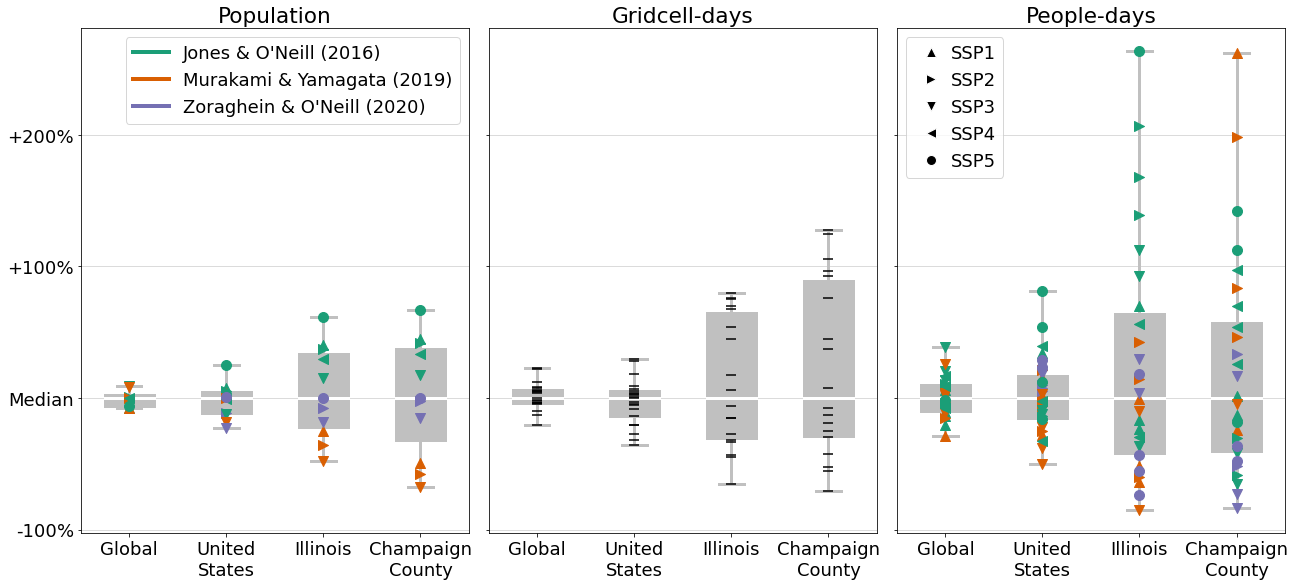

In [178]:
################################
### MAIN FIGURE
################################

fig, axs = plt.subplots(1,3, figsize=(18,8), sharey=True)

color = 'silver'
width=0.5
lw=3
ms=100

#############
# Population
#############
ax=axs[0]

# Global
pop_unique = global_out.drop_duplicates(subset=['pop'])
draw_pop_boxplot(pop_unique, ax, 1)

# US
pop_unique = us_out.drop_duplicates(subset=['pop'])
draw_pop_boxplot(pop_unique, ax, 2)
        
# Illinois
pop_unique = il_out_plot.drop_duplicates(subset=['pop'])
draw_pop_boxplot(pop_unique, ax, 3)
        
# Champaign
pop_unique = county_out_plot.drop_duplicates(subset=['pop'])
draw_pop_boxplot(pop_unique, ax, 4)

# Figure settings
ax.set_title('Population')
ax.set_yticks([0., 1.0, 2.0, 3.0])
ax.set_yticklabels(['-100%', 'Median', '+100%', '+200%'])
ax.set_xticklabels(['Global', 'United\nStates', 'Illinois', 'Champaign\nCounty'])
ax.grid(axis='y', color='lightgray')

# Custom legend
legend_elements = [Line2D([0], [0], color=method_color_map['jo16'], lw=4, label="Jones & O'Neill (2016)"),
                Line2D([0], [0], color=method_color_map['my19'], lw=4, label="Murakami & Yamagata (2019)"),
                Line2D([0], [0], color=method_color_map['zo20'], lw=4, label="Zoraghein & O'Neill (2020)")]

ax.legend(handles = legend_elements)

#################
# Gridcell days
#################
ax=axs[1]

# Global
gc_unique = global_out.drop_duplicates(subset=['gridcell_days'])
draw_gricell_boxplot(gc_unique, ax, 1)

# US
gc_unique = us_out.drop_duplicates(subset=['gridcell_days'])
draw_gricell_boxplot(gc_unique, ax, 2)

# Illinois
gc_unique = il_out_plot.drop_duplicates(subset=['gridcell_days'])
draw_gricell_boxplot(gc_unique, ax, 3)

# Champaign
gc_unique = county_out_plot.drop_duplicates(subset=['gridcell_days'])
draw_gricell_boxplot(gc_unique, ax, 4)

# Figure settings
ax.set_title('Gridcell-days')
ax.set_xticklabels(['Global', 'United\nStates', 'Illinois', 'Champaign\nCounty'])
ax.grid(axis='y', color='lightgray')

###############
# People days
###############
ax=axs[2]

# Global
draw_ppldays_boxplot(global_out, ax, 1)
        
# US
draw_ppldays_boxplot(us_out, ax, 2)
        
# Illinois
draw_ppldays_boxplot(il_out_plot, ax, 3)

# Champaign
draw_ppldays_boxplot(county_out_plot, ax, 4)
        
# Figure settings
ax.set_title('People-days')
ax.set_xticklabels(['Global', 'United\nStates', 'Illinois', 'Champaign\nCounty'])
ax.grid(axis='y', color='lightgray')

# Custom legend
legend_elements = [Line2D([0], [0], marker=ssp_marker_map['ssp1'], color='w', markerfacecolor='black', markersize=10, label='SSP1'),
                Line2D([0], [0], marker=ssp_marker_map['ssp2'], color='w', markerfacecolor='black', markersize=10, label='SSP2'),
                Line2D([0], [0], marker=ssp_marker_map['ssp3'], color='w', markerfacecolor='black', markersize=10, label='SSP3'),
                  Line2D([0], [0], marker=ssp_marker_map['ssp4'], color='w', markerfacecolor='black', markersize=10, label='SSP4'),
                  Line2D([0], [0], marker=ssp_marker_map['ssp5'], color='w', markerfacecolor='black', markersize=10, label='SSP5')]

ax.legend(handles = legend_elements, ncol=1, handletextpad=0.1)

plt.tight_layout(pad=0.1)
plt.savefig('./uncertainty_scales.pdf')
# plt.show()

In [181]:
############# OLD #########################

In [182]:
# ################################
# ### MAIN FIGURE
# ################################

# fig, axs = plt.subplots(2,2, figsize=(16,10), sharey='row')

# color = 'silver'
# width=0.5
# lw=3
# ms=100

# #############
# # Global
# #############
# ax=axs[0,0]

# # Population
# pop_unique = global_out.drop_duplicates(subset=['pop'])

# bp_pop = ax.boxplot(pop_unique['pop_med'], positions=[1],
#                medianprops=dict(linewidth=lw, color='white'),
#                boxprops=dict(linewidth=lw, color=color),
#                whiskerprops=dict(linewidth=lw, color=color),
#                capprops=dict(linewidth=lw, color=color),
#                showfliers=True, widths=width, whis=(0,100),
#                patch_artist=True)

# for ssp in ssp_marker_map.keys():
#     for method in method_color_map.keys():
#         pop_unique_plot = pop_unique.query('ssp == "' + ssp + '" and method == "' + method + '"')
#         ax.scatter(x=[1]*len(pop_unique_plot), y=pop_unique_plot['pop_med'], 
#                    marker=ssp_marker_map[ssp], 
#                    color=method_color_map[method],
#                    zorder=100, s=ms) 

# # Gridcell days > 35C
# gc_unique = global_out.drop_duplicates(subset=['gridcell_days'])

# bp_gc = ax.boxplot(gc_unique['gridcell_days_med'], positions=[2],
#                 medianprops=dict(linewidth=lw, color='white'),
#                boxprops=dict(linewidth=lw, color=color),
#                whiskerprops=dict(linewidth=lw, color=color),
#                capprops=dict(linewidth=lw, color=color),
#                showfliers=True, widths=width,
#                patch_artist=True,
#                   whis=(0,100))

# ax.scatter(x = [2]*len(global_out), y=global_out['gridcell_days_med'], marker='_', s=ms, zorder=100, color='black')

# # People days
# bp_ppl = ax.boxplot(global_out['people_days_med'], positions=[3],
#                 medianprops=dict(linewidth=lw, color='white'),
#                boxprops=dict(linewidth=lw, color=color),
#                whiskerprops=dict(linewidth=lw, color=color),
#                capprops=dict(linewidth=lw, color=color),
#                showfliers=True, widths=width,
#                patch_artist=True)

# # Boxplot color
# for box in [bp_pop, bp_gc, bp_ppl]:
#     for patch in box['boxes']:
#         patch.set_facecolor(color)
        
# global_out_sample = global_out.sort_values(by='people_days_med')[::8].append(global_out.sort_values(by='people_days_med').iloc[-1])
# for ssp in ssp_marker_map.keys():
#     for method in method_color_map.keys():
#         global_sample_plot = global_out_sample.query('ssp == "' + ssp + '" and method == "' + method + '"')
#         ax.scatter(x=[3]*len(global_sample_plot), y=global_sample_plot['people_days_med'], 
#                    marker=ssp_marker_map[ssp], 
#                    color=method_color_map[method],
#                    zorder=100,
#                   s=ms)
        
# # Figure settings
# ax.set_title('Global')
# ax.set_yticks([0.8, 1.0, 1.2, 1.4])
# ax.set_yticklabels(['-20%', 'Median', '+20%', '+40%'])
# ax.set_xticklabels(['Population', 'Gridcell-days', 'People-days'])
# ax.grid(axis='y', color='lightgray')

# #############
# # USA
# #############
# ax=axs[0,1]

# # Population
# pop_unique = us_out.drop_duplicates(subset=['pop'])

# bp_pop = ax.boxplot(pop_unique['pop_med'], positions=[1],
#                medianprops=dict(linewidth=lw, color='white'),
#                boxprops=dict(linewidth=lw, color=color),
#                whiskerprops=dict(linewidth=lw, color=color),
#                capprops=dict(linewidth=lw, color=color),
#                showfliers=True, widths=width, whis=(0,100),
#                patch_artist=True)

# for ssp in ssp_marker_map.keys():
#     for method in method_color_map.keys():
#         pop_unique_plot = pop_unique.query('ssp == "' + ssp + '" and method == "' + method + '"')
#         ax.scatter(x=[1]*len(pop_unique_plot), y=pop_unique_plot['pop_med'], 
#                    marker=ssp_marker_map[ssp], 
#                    color=method_color_map[method],
#                    zorder=100,
#                   s=ms) 

# # Gridcell days > 35C
# gc_unique = us_out.drop_duplicates(subset=['gridcell_days'])

# bp_gc = ax.boxplot(gc_unique['gridcell_days_med'], positions=[2],
#                 medianprops=dict(linewidth=lw, color='white'),
#                boxprops=dict(linewidth=lw, color=color),
#                whiskerprops=dict(linewidth=lw, color=color),
#                capprops=dict(linewidth=lw, color=color),
#                showfliers=True, widths=width,
#                patch_artist=True,
#                whis=(0,100))

# ax.scatter(x = [2]*len(us_out), y=us_out['gridcell_days_med'], marker='_', s=ms, zorder=100, color='black')

# # People days
# bp_ppl = ax.boxplot(us_out['people_days_med'], positions=[3],
#                 medianprops=dict(linewidth=lw, color='white'),
#                boxprops=dict(linewidth=lw, color=color),
#                whiskerprops=dict(linewidth=lw, color=color),
#                capprops=dict(linewidth=lw, color=color),
#                showfliers=True, widths=width,
#                patch_artist=True,
#                 whis=(0,100))

# # Boxplot color
# for box in [bp_pop, bp_gc, bp_ppl]:
#     for patch in box['boxes']:
#         patch.set_facecolor(color)
        
# us_out_sample = us_out.sort_values(by='people_days_med')[::8].append(us_out.sort_values(by='people_days_med').iloc[-1])
# for ssp in ssp_marker_map.keys():
#     for method in method_color_map.keys():
#         us_sample_plot = us_out_sample.query('ssp == "' + ssp + '" and method == "' + method + '"')
#         ax.scatter(x=[3]*len(us_sample_plot), y=us_sample_plot['people_days_med'], 
#                    marker=ssp_marker_map[ssp], 
#                    color=method_color_map[method],
#                    zorder=100,
#                   s=ms)
        
# # Figure settings
# ax.set_title('United States')
# ax.set_yticks([0.6, 1.0, 1.4, 1.8])
# ax.set_yticklabels(['-40%', 'Median', '+40%', '+80%'])
# ax.set_xticklabels(['Population', 'Gridcell-days', 'People-days'])
# ax.grid(axis='y', color='lightgray')

# #############
# # Illinois
# #############
# ax=axs[1,0]

# # Population
# pop_unique = il_out_plot.drop_duplicates(subset=['pop'])
# pop_unique['pop_med'] = pop_unique['pop'] / np.median(pop_unique['pop'])

# bp_pop = ax.boxplot(pop_unique['pop_med'], positions=[1],
#                medianprops=dict(linewidth=lw, color='white'),
#                boxprops=dict(linewidth=lw, color=color),
#                whiskerprops=dict(linewidth=lw, color=color),
#                capprops=dict(linewidth=lw, color=color),
#                showfliers=True, widths=width, whis=(0,100),
#                patch_artist=True)

# for ssp in ssp_marker_map.keys():
#     for method in method_color_map.keys():
#         pop_unique_plot = pop_unique.query('ssp == "' + ssp + '" and method == "' + method + '"')
#         ax.scatter(x=[1]*len(pop_unique_plot), y=pop_unique_plot['pop_med'], 
#                    marker=ssp_marker_map[ssp], 
#                    color=method_color_map[method],
#                    zorder=100,
#                   s=ms) 

# # Gridcell days > 35C
# gc_unique = il_out_plot.drop_duplicates(subset=['gridcell_days'])
# gc_unique = gc_unique[~gc_unique.model.isin(outliers)] # Can choose to drop outliers or not

# gc_unique['gridcell_days_med'] = gc_unique['gridcell_days'] / np.median(gc_unique['gridcell_days'])

# bp_gc = ax.boxplot(gc_unique['gridcell_days_med'], positions=[2],
#                 medianprops=dict(linewidth=lw, color='white'),
#                boxprops=dict(linewidth=lw, color=color),
#                whiskerprops=dict(linewidth=lw, color=color),
#                capprops=dict(linewidth=lw, color=color),
#                showfliers=True, widths=width,
#                patch_artist=True,
#                whis=(0,100))

# ax.scatter(x = [2]*len(gc_unique), y=gc_unique['gridcell_days_med'], marker='_', s=ms, zorder=100, color='black')

# # People days
# bp_ppl = ax.boxplot(il_out_plot['people_days_med'], positions=[3],
#                 medianprops=dict(linewidth=lw, color='white'),
#                boxprops=dict(linewidth=lw, color=color),
#                whiskerprops=dict(linewidth=lw, color=color),
#                capprops=dict(linewidth=lw, color=color),
#                showfliers=True, widths=width,
#                patch_artist=True,
#                 whis=(0,100))

# # Boxplot color
# for box in [bp_pop, bp_gc, bp_ppl]:
#     for patch in box['boxes']:
#         patch.set_facecolor(color)
           
# il_out_sample = il_out_plot.sort_values(by='people_days_med')[::8].append(il_out_plot.sort_values(by='people_days_med').iloc[-1])

# for ssp in ssp_marker_map.keys():
#     for method in method_color_map.keys():
#         il_sample_plot = il_out_sample.query('ssp == "' + ssp + '" and method == "' + method + '"')
#         ax.scatter(x=[3]*len(il_sample_plot), y=il_sample_plot['people_days_med'], 
#                    marker=ssp_marker_map[ssp], 
#                    color=method_color_map[method],
#                    zorder=100,
#                   s=ms)
        
# # Figure settings
# ax.set_title('Illinois')
# ax.set_yticks([0.0, 1.0, 2.0, 3.0])
# ax.set_yticklabels(['-100%', 'Median', '+100%', '+200%'])
# ax.set_xticklabels(['Population', 'Gridcell-days', 'People-days'])
# ax.grid(axis='y', color='lightgray')

# # Custom legend
# ms=ms
# legend_elements = [Line2D([0], [0], marker=ssp_marker_map['ssp1'], color='w', markerfacecolor='black', markersize=10, label='SSP1'),
#                 Line2D([0], [0], marker=ssp_marker_map['ssp2'], color='w', markerfacecolor='black', markersize=10, label='SSP2'),
#                 Line2D([0], [0], marker=ssp_marker_map['ssp3'], color='w', markerfacecolor='black', markersize=10, label='SSP3'),
#                   Line2D([0], [0], marker=ssp_marker_map['ssp4'], color='w', markerfacecolor='black', markersize=10, label='SSP4'),
#                   Line2D([0], [0], marker=ssp_marker_map['ssp5'], color='w', markerfacecolor='black', markersize=10, label='SSP5')]

# ax.legend(handles = legend_elements, ncol=3, handletextpad=0.1)#, bbox_to_anchor=(0.25, -0.1), ncol=5)

# #############
# # Champaign
# #############
# ax=axs[1,1]

# # Population
# pop_unique = county_out_plot.drop_duplicates(subset=['pop'])
# pop_unique['pop_med'] = pop_unique['pop'] / np.median(pop_unique['pop'])

# bp_pop = ax.boxplot(pop_unique['pop_med'], positions=[1],
#                medianprops=dict(linewidth=lw, color='white'),
#                boxprops=dict(linewidth=lw, color=color),
#                whiskerprops=dict(linewidth=lw, color=color),
#                capprops=dict(linewidth=lw, color=color),
#                showfliers=True, widths=width, whis=(0,100),
#                patch_artist=True)

# for ssp in ssp_marker_map.keys():
#     for method in method_color_map.keys():
#         pop_unique_plot = pop_unique.query('ssp == "' + ssp + '" and method == "' + method + '"')
#         ax.scatter(x=[1]*len(pop_unique_plot), y=pop_unique_plot['pop_med'], 
#                    marker=ssp_marker_map[ssp], 
#                    color=method_color_map[method],
#                    zorder=100,
#                   s=ms) 

# # Gridcell days > 35C
# gc_unique = county_out_plot.drop_duplicates(subset=['gridcell_days'])
# gc_unique = gc_unique[~gc_unique.model.isin(outliers)] # Can choose to drop outliers or not

# gc_unique['gridcell_days_med'] = gc_unique['gridcell_days'] / np.median(gc_unique['gridcell_days'])

# bp_gc = ax.boxplot(gc_unique['gridcell_days_med'], positions=[2],
#                 medianprops=dict(linewidth=lw, color='white'),
#                boxprops=dict(linewidth=lw, color=color),
#                whiskerprops=dict(linewidth=lw, color=color),
#                capprops=dict(linewidth=lw, color=color),
#                showfliers=True, widths=width,
#                patch_artist=True,
#                whis=(0,100))

# ax.scatter(x = [2]*len(gc_unique), y=gc_unique['gridcell_days_med'], marker='_', s=ms, zorder=100, color='black')

# # People days
# bp_ppl = ax.boxplot(county_out_plot['people_days_med'], positions=[3],
#                 medianprops=dict(linewidth=lw, color='white'),
#                boxprops=dict(linewidth=lw, color=color),
#                whiskerprops=dict(linewidth=lw, color=color),
#                capprops=dict(linewidth=lw, color=color),
#                showfliers=True, widths=width,
#                patch_artist=True,
#                 whis=(0,100))

# # Boxplot color
# for box in [bp_pop, bp_gc, bp_ppl]:
#     for patch in box['boxes']:
#         patch.set_facecolor(color)
           
# county_out_sample = county_out_plot.sort_values(by='people_days_med')[::12].append(county_out_plot.sort_values(by='people_days_med').iloc[-1])

# for ssp in ssp_marker_map.keys():
#     for method in method_color_map.keys():
#         county_sample_plot = county_out_sample.query('ssp == "' + ssp + '" and method == "' + method + '"')
#         ax.scatter(x=[3]*len(county_sample_plot), y=county_sample_plot['people_days_med'], 
#                    marker=ssp_marker_map[ssp], 
#                    color=method_color_map[method],
#                    zorder=100,
#                   s=ms)
        
# # Figure settings
# ax.set_title('Champaign County')
# ax.set_yticks([0.0, 1.0, 2.0, 3.0])
# ax.set_yticklabels(['-100%', 'Median', '+100%', '+200%'])
# ax.set_xticklabels(['Population', 'Gridcell-days', 'People-days'])
# ax.grid(axis='y', color='lightgray')

# # Custom legend
# legend_elements = [Line2D([0], [0], color=method_color_map['jo16'], lw=4, label="Jones & O'Neill (2016)"),
#                 Line2D([0], [0], color=method_color_map['my19'], lw=4, label="Murakami & Yamagata (2019)"),
#                 Line2D([0], [0], color=method_color_map['zo20'], lw=4, label="Zoraghein & O'Neill (2020)")]

# ax.legend(handles = legend_elements)#, bbox_to_anchor=(0.25, -0.1), ncol=5)

# plt.tight_layout(pad=2.0)
# # plt.savefig('./uncertainty_scales.pdf')
# # plt.show()